In this notebook we want to examine whether the mutations in positions with extreme CAI/mfe are more pathogenic than mutations found in other positions. We will use ClinVar data and keep variants labeled as Pathogenic or Benign. 

## Imports

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
from scipy import stats

## Functions

In [11]:
''' For a given paramter set and a given mutation, get its z-score and p-value '''
def get_scores_parameter_set(measure: str, permutation: str, gene_id: str, mut_start_pos: int) -> [float, float]:
    
    path = f"../Results/AllGenes/{measure}/z-scores/{gene_id}_{permutation}.pickle"
    df = pd.read_pickle(path)
    zscore = df.loc[mut_start_pos]["z-score"]
    pval = df.loc[mut_start_pos]["corrected p-value"]
    
    return(zscore, pval)
   

In [12]:
''' Get the z-scores and p-vals of a single ClinVar variant according to all measures '''
def get_scores_and_pvals(mut_info: dict, gene_protein_dict: dict, cds_chrom_dict: dict) -> [float, float, float, float, float, float, float, float]:
    
    try:
    
        #basic info of the mutation
        mut_start = mut_info["Start_Position"] # 1-based start position, relative to the chromosome
        gene_id = mut_info["Gene stable ID"]
        protein_id = gene_protein_dict[gene_id]

        #map from a 1-based position relative to the chromosome to a 0-based position relative to the cds
        cds2chr = cds_chrom_dict[gene_id, protein_id] #mapping cds_pos -> chrm_pos of the current gene. 0-based. 
        chr2cds = {v: k for k, v in cds2chr.items()} #reverse the dictionary, obtain a mapping of chrm_pos -> cds pos. 0-based. 
        cds_mut_start = chr2cds[mut_start - 1] #0-based start position relative to the CDS. 
        aa_mut_start = int(np.floor(cds_mut_start / 3)) #results of CAI are in codons, not nts

        #get scores from the dfs. Each protein has a seperate df that containes the scores of each of its cds positions
        mfe_ver_zscore, mfe_ver_pval = get_scores_parameter_set("mfe", "vertical", gene_id, cds_mut_start)
        mfe_col_zscore, mfe_col_pval = get_scores_parameter_set("mfe", "column", gene_id, cds_mut_start)
        cai_ver_zscore, cai_ver_pval = get_scores_parameter_set("CAI", "vertical", gene_id, aa_mut_start)
        cai_col_zscore, cai_col_pval = get_scores_parameter_set("CAI", "column", gene_id, aa_mut_start)

        return(mfe_ver_zscore, mfe_ver_pval,
               mfe_col_zscore, mfe_col_pval,
               cai_ver_zscore, cai_ver_pval,
               cai_col_zscore, cai_col_pval)
    
    except:
        
        return(None, None, None, None, None, None, None, None)

In [13]:
''' we have the group of ClinVar variants, and the groups of ClinVar variants with extreme z-scores. 
here we check the pathogenic/benign ratios in these groups '''

def get_patho_benign_ratio(df: pd.DataFrame, measure: str, low_percentile: float, high_percentile: float) -> [pd.DataFrame, float, float, pd.DataFrame]:

    df = df[~df[measure].isna()] #for example if we are looking at mfe z-scores - remove mutations that dont have this score
    df = df.drop_duplicates(subset=['mut_id']) #some mutations have duplicates with the same scores and they shouldnt count more than once.. 
    original_ratio = df["Clinical significance"].value_counts() / df["Clinical significance"].shape[0]
    
    bottom_percentile = np.percentile(df[measure], low_percentile)
    top_percentile = np.percentile(df[measure], high_percentile)

    df_low = df[df[measure] <= bottom_percentile].copy()
    df_high = df[df[measure] >= top_percentile].copy()

    ratio_low = df_low["Clinical significance"].value_counts() / df_low["Clinical significance"].shape[0]
    ratio_high = df_high["Clinical significance"].value_counts() / df_high["Clinical significance"].shape[0]
    
    ratios_df = pd.DataFrame()
    ratios_df["original"] = original_ratio
    ratios_df["ratio_low"] = ratio_low
    ratios_df["ratio_high"] = ratio_high
    
    nums_df = ratios_df * [df.shape[0], df_low.shape[0], df_high.shape[0]]
    nums_df = nums_df.astype(int)

    hg_p_low, hg_p_high = calc_hg_pval(nums_df)

    return(ratios_df, hg_p_low, hg_p_high, nums_df) 

In [14]:
''' Intersection between vertical and column extreme percents. measure here is either mfe or cai. 
We get the ratio of pathogenic/benign variants in the group of variants that received extreme
z-scores according to both the column and vertical randomizations''' 

def get_patho_benign_ratio_both(df: pd.DataFrame, measure: str, low_percentile: float, high_percentile: float) -> [pd.DataFrame, float, float, pd.DataFrame]:

    #keep variants that have both measures (mfe_v_z & mfe_c_z, or cai_v_z and cai_c_z)
    
    df = df[(~df[f"{measure}_v_z"].isna()) & (~df[f"{measure}_c_z"].isna())] #for example if we are looking at mfe z-scores - remove mutations that dont have this score
    df = df.drop_duplicates(subset=['mut_id']) #some mutations have duplicates with the same scores and they shouldnt count more than once.. 
    original_ratio = df["Clinical significance"].value_counts() / df["Clinical significance"].shape[0]
    
    #get the top and bottom percentiles according to both measures
    bottom_percentile, top_percentile = np.percentile(df[f"{measure}_v_z"], low_percentile), np.percentile(df[f"{measure}_v_z"], high_percentile)
    df_low_v, df_high_v= df[df[f"{measure}_v_z"] <= bottom_percentile].copy(), df[df[f"{measure}_v_z"] >= top_percentile].copy()

    bottom_percentile, top_percentile = np.percentile(df[f"{measure}_c_z"], low_percentile), np.percentile(df[f"{measure}_c_z"], high_percentile)
    df_low_c, df_high_c= df[df[f"{measure}_c_z"] <= bottom_percentile].copy(), df[df[f"{measure}_c_z"] >= top_percentile].copy()
    
    #get the shared variants
    low_v_mut_ids = list(df_low_v["mut_id"].values)
    low_c_mut_ids = list(df_low_c["mut_id"].values)
    high_v_mut_ids = list(df_high_v["mut_id"].values)
    high_c_mut_ids = list(df_high_c["mut_id"].values)
    

    low_variants = [mut_id for mut_id in low_v_mut_ids if mut_id in low_c_mut_ids]
    high_variants = [mut_id for mut_id in high_v_mut_ids if mut_id in high_c_mut_ids]
    df_low = df_low_v[df_low_v["mut_id"].isin(low_variants)].copy()
    df_high = df_high_v[df_high_v["mut_id"].isin(high_variants)].copy()
    
    ratio_low = df_low["Clinical significance"].value_counts() / df_low["Clinical significance"].shape[0]
    ratio_high = df_high["Clinical significance"].value_counts() / df_high["Clinical significance"].shape[0]
    
    ratios_df = pd.DataFrame()
    ratios_df["original"] = original_ratio
    ratios_df["ratio_low"] = ratio_low
    ratios_df["ratio_high"] = ratio_high
    
    nums_df = ratios_df * [df.shape[0], df_low.shape[0], df_high.shape[0]]
    nums_df = nums_df.astype(int)

    hg_p_low, hg_p_high = calc_hg_pval(nums_df)
    
    return(ratios_df, hg_p_low, hg_p_high, nums_df) 

In [15]:
''' Plot the pathogenic/benign ratios in the three groups and see if there is an enrichement '''
def plot_bar_chart(ratios_df: pd.DataFrame, nums_df: pd.DataFrame, measure: str, low_percentile: float, high_percentile: float) -> None:
    

    group_data = np.array([
        [ratios_df.loc['Pathogenic', 'original'], ratios_df.loc['Benign', 'original']],
        [ratios_df.loc['Pathogenic', 'ratio_low'], ratios_df.loc['Benign', 'ratio_low']],
        [ratios_df.loc['Pathogenic', 'ratio_high'], ratios_df.loc['Benign', 'ratio_high']]
    ])
    
    # Calculate the pathogenic ratio and benign ratio for each group
    patho_ratio = group_data[:, 0] / group_data.sum(axis=1)
    benign_ratio = group_data[:, 1] / group_data.sum(axis=1)

    # Create a bar chart with stacked bars for each group
    x_labels = [f'original\n(n = {int(nums_df["original"].sum())})', 
                f'{low_percentile} percentile\n(n = {int(nums_df["ratio_low"].sum())})', 
                f'{high_percentile} percentile\n(n = {int(nums_df["ratio_high"].sum())})']
    x_pos = np.arange(len(x_labels))

    fig, ax = plt.subplots()

    bar_width = 0.5

    # Plot the bars for pathogenic ratio
    patho_bars = ax.bar(x_pos, patho_ratio, bar_width, label='Pathogenic', color='blue')

    # Add labels for pathogenic ratio on top of the bars
    dist_from_bottom = 0.3
    for bar in patho_bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, dist_from_bottom, f'{height:.2f}', ha='center', color='white')

    # Plot the bars for benign ratio
    benign_bars = ax.bar(x_pos, benign_ratio, bar_width, label='Benign', color='orange', bottom=patho_ratio)

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels)

    ax.set_ylabel('Ratio')
    ax.legend([patho_bars[0], benign_bars[0]], ['Pathogenic', 'Benign'])
    
    m = "MFE" if "mfe" in measure else "CAI"
    perm = "vertical" if "v" in measure else "column"
    if "z" not in measure:
        plt.title(f"Z-scores obtained with {m}")
    else:
        plt.title(f"Z-scores obtained with {m}, {perm} permutations")

    plt.show()



In [16]:
''' Create randomizations (choose random ClinVar variants) in the size of the original groups to
obtain an empirical p-value '''

def calc_emperical_pval(clinvar_df: pd.DataFrame, measure: str, num_random_groups: int, low_percentile: float, high_percentile: float) -> [float, float]:
    
    clinvar_df = clinvar_df[~clinvar_df[measure].isna()] #remove mutations that don't have a score for the current measure
    clinvar_df = clinvar_df.drop_duplicates(subset=['mut_id']) #remove duplicate mutations
    
    bottom_percentile, top_percentile = np.percentile(clinvar_df[measure], low_percentile), np.percentile(clinvar_df[measure], high_percentile) #calculate 
    #percentile 1 and 99 for example
    
    df_low, df_high = clinvar_df[clinvar_df[measure] <= bottom_percentile].copy(),clinvar_df[clinvar_df[measure] >= top_percentile].copy() #get the mutations
    #below bottom_percentile and above top_percentile for the current score
    
    num_muts_low, num_muts_high = df_low.shape[0], df_high.shape[0] # number of mutations in these two groups (should be very similar but not necceserily identical)
    num_patho_low, num_patho_high = df_low["Clinical significance"].value_counts()["Pathogenic"] , df_high["Clinical significance"].value_counts()["Pathogenic"] #num 
    #pathogenic mutations in those groups
    
    #get the number of pathogenic mutations in randomly chosen groups of the same size:
    
    num_patho_rand_low = np.zeros(num_random_groups)
    num_patho_rand_high = np.zeros(num_random_groups)
    
    for i in range(num_random_groups):
        patho_rand_low = clinvar_df.sample(n = num_muts_low)["Clinical significance"].value_counts()["Pathogenic"] #choose randomly a group of size "num_muts1"
        #and see how many pathogenic mutations are in it 
        patho_rand_high = clinvar_df.sample(n = num_muts_high)["Clinical significance"].value_counts()["Pathogenic"] 
        num_patho_rand_low[i] = patho_rand_low #save the scores
        num_patho_rand_high[i] = patho_rand_high
        
    p_val_low = 1 - np.sum(num_patho_rand_low < num_patho_low) / (num_random_groups)
    p_val_high = 1 - np.sum(num_patho_rand_high < num_patho_high) / (num_random_groups)
    
    return(p_val_low, p_val_high)
 

## Main

In [3]:
''' Get the variants from ClinVar '''
clinvar_df = pd.read_pickle("../co_trans_data/ClinVar_processed_df.pickle")

In [6]:
''' Get needed variables to map the "mut_start" to  a position on the gene's cds sequence '''

# a dictionary that maps the gene ids to the protein ids that we used: 
gene_protein_dict = pd.read_pickle("../co_trans_data/gene_protein_dict.pickle") #map between the gene to the protein id used by ensembl

# a dictionary that maps the cds positions to the chromosome positions of our genes
cds_to_chrom_dict = pd.read_pickle("../co_trans_data/cds_to_chrom_dict_with_protein_id.pickle") #dictionary mapping between CDS to chromosome positions


In [155]:
''' get the z-scores and p-vals for all variants on ClinVar, and save it'''

clinvar_df[["mfe_v_z","mfe_v_p",
            "mfe_c_z","mfe_c_p",
            "cai_v_z","cai_v_p", 
            "cai_c_z","cai_c_p"]] = clinvar_df.apply(lambda x: pd.Series(get_scores_and_pvals(x, gene_protein_dict, cds_to_chrom_dict)), axis = 1)

with open('../Results/AllGenes/validation/z-scores/ClinVar/clinvar_df_with_zscores_pvals', 'wb') as handle:
    pickle.dump(clinvar_df, handle, protocol=3)


In [2]:
''' Load the df with the z-scores and p-vals '''
clinvar_df = pd.read_pickle('../Results/AllGenes/validation/z-scores/ClinVar/clinvar_df_with_zscores_pvals')

## plot and see it there is an enrichement of pathogenic mutations in the groups of extreme z-scores

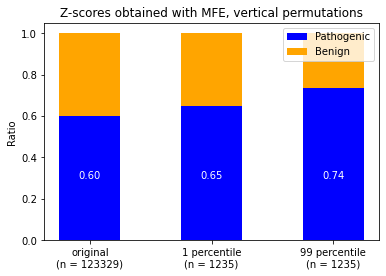

hg pvalue for lowest 1 percentile: 0.00019172896427631933 
hg pvalue for highest 99 percentile: 5.638366615316182e-24


In [159]:
measure = "mfe_v_z"
low_percentile = 1
high_percentile = 99

ratios_df, hg_p_low, hg_p_high, nums_df = get_patho_benign_ratio(clinvar_df, measure, low_percentile, high_percentile)
plot_bar_chart(ratios_df, nums_df, measure, low_percentile, high_percentile)

print(f"hg pvalue for lowest {low_percentile} percentile: {hg_p_low} \nhg pvalue for highest {high_percentile} percentile: {hg_p_high}")


In [10]:
''' Calculate and save the empirical p-value '''
num_random_groups = 10000
p_vals = calc_emperical_pval(clinvar_df, measure, num_random_groups, low_percentile, high_percentile)

with open(f"../Results/AllGenes/validation/z-scores/ClinVar/{measure}_{low_percentile}_emp_pvals", 'wb') as handle:
    pickle.dump(p_vals, handle)


## intersection of permutation methods

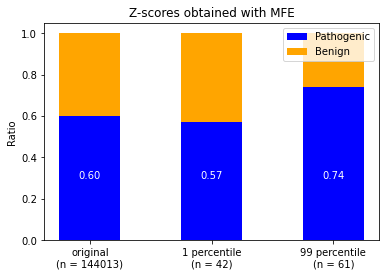

hg pvalue for lowest 1 percentile: 0.6966742243004532 
hg pvalue for highest 99 percentile: 0.016261650661209194


In [71]:
measure = "mfe"
low_percentile = 1
high_percentile = 99


ratios_df, hg_p_low, hg_p_high, nums_df = get_patho_benign_ratio_both(clinvar_df, measure, low_percentile, high_percentile)
plot_bar_chart(ratios_df, nums_df, measure, low_percentile, high_percentile)

print(f"hg pvalue for lowest {low_percentile} percentile: {hg_p_low} \nhg pvalue for highest {high_percentile} percentile: {hg_p_high}")
